# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [3]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [4]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("a.tolkachev") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [307]:
import time

def timer(f):
    def tmp(*args, **kwargs):
        t = time.time()
        res = f(*args, **kwargs)
        print "Time: %f" % (time.time()-t)
        return res

    return tmp

In [328]:
class Clustering:
    
    def __init__(self, k = 2, linkage = 'average'):
        self.k = k
        self.linkage = linkage
        return
        
    def fit(self, x, y=None):
        self.x_len = len(x)
        if(self.x_len <= self.k):
            raise ValueError ('Wrong number of clusters. Should be less than {}'.format(self.x_len))
        self.clusters = [[np.array(obj)] for obj in x]
        return self
    
    def predict(self, x):
        while self.x_len > self.k:
            min_dist = inf
            ind_i = 0
            ind_j = 1
            for i in xrange(self.x_len):
                for j in xrange(i+1, self.x_len):
                    dist = self.distance(i, j)
                    if dist < min_dist:
                        min_dist = dist
                        ind_i = i
                        ind_j = j
            self.clusters[ind_i] += self.clusters[ind_j]
            del self.clusters[ind_j]
            self.x_len -= 1
        #print self.clusters
        index_vector = np.zeros(len(x)).astype(int)
        for i, obj in enumerate(x):
            index_vector[i] = self.get_cluster_index(obj)
        return index_vector 
    
    @timer
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)
    
    def get_cluster_index(self, obj):
        for j, cluster in enumerate(self.clusters):
            for elem in cluster:
                if np.allclose(elem, obj):
                    return j
    
    def distance(self, i, j):
        res_dist = np.linalg.norm(self.clusters[i][0] - self.clusters[j][0])
        if self.linkage == 'single':
            #single linkage
            for cl1 in self.clusters[i]:
                for cl2 in self.clusters[j]:
                    dist = np.linalg.norm(cl1 - cl2)
                    if dist < res_dist:
                        res_dist = dist
            
        elif self.linkage == 'complete':
            #complete linkage
            for cl1 in self.clusters[i]:
                for cl2 in self.clusters[j]:
                    dist = np.linalg.norm(cl1 - cl2)
                    if dist > res_dist:
                        res_dist = dist
                    
        elif self.linkage == 'average':
            #average linkage
            res_dist = 0
            for cl1 in self.clusters[i]:
                for cl2 in self.clusters[j]:
                    res_dist += np.linalg.norm(cl1 - cl2)
            res_dist /= (len(self.clusters[i]) * len(self.clusters[j]))
        
        else:
            raise TypeError('Unknown linkage')
        
        return res_dist


In [205]:
# inertia
def inertia(dataset, labels):
    N = len(np.unique(labels))
    M = (dataset[0] - dataset[0]).astype(float)
    cl_len = np.bincount(labels)
    res = 0
    for i in xrange(N):
        for j, cl in enumerate(labels):
            if cl == i:
                M += dataset[j]
        M /= cl_len[i]
        for j, cl in enumerate(labels):
            if cl == i:
                res += (np.sum((M - dataset[j])**2))/cl_len[i]
        M -= M
    return res

In [204]:
# Silhouette
def silhouette(dataset, labels):
    distances = smt.pairwise_distances(dataset)
    n = labels.shape[0]
    A = np.array([intra_cluster_distance(distances[i], labels, i)
                  for i in range(n)])
    B = np.array([nearest_cluster_distance(distances[i], labels, i)
                  for i in range(n)])
    sil_samples = (B - A) / np.maximum(A, B)
    return np.mean(sil_samples)

def intra_cluster_distance(distances_row, labels, i):
    mask = labels == labels[i]
    mask[i] = False
    if not np.any(mask):
        # cluster of size 1
        return 0
    a = np.mean(distances_row[mask])
    return a

def nearest_cluster_distance(distances_row, labels, i):
    label = labels[i]
    b = np.min([np.mean(distances_row[labels == cur_label])
               for cur_label in set(labels) if not cur_label == label])
    return b

In [223]:
# diameter
def diameter(dataset, labels):
    avg = 0
    N = dataset.shape[0]
    K = len(np.unique(labels))
    kIndices = [np.flatnonzero(labels == k) for k in xrange(K)]
    for k in xrange(K):
        distances = smt.pairwise_distances(dataset[kIndices[k]])
        avg += np.amax(distances)
    return avg / K

In [305]:
# test
test = np.array([[1,1], [1,2], [2,1], [2,2], [5,5], [5,6], [6,5], [6,6]])
for cl_num in xrange(1, 10):
    try:
        cluster_labels = Clustering(k = cl_num, linkage = 'average').fit_predict(test)
        print cluster_labels
        
        # with inertia
        inertia_mtr = inertia(test, cluster_labels)
        print "INERTIA: For n_clusters =", cl_num, "Inertia is :", inertia_mtr
        
         # with diameter
        diam_mtr = diameter(test, cluster_labels)
        print "DIAMETER: For n_clusters =", cl_num, "diameter_avg is :", diam_mtr
        
        # with silhouette
        #silhouette_avg = smt.silhouette_score(test, cluster_labels)
        #print "SILHOUETTE: For n_clusters =", cl_num, "The average silhouette_score is :", silhouette_avg
                
        # with silhouette
        silhouette_mtr = silhouette(test, cluster_labels)
        print "SILHOUETTE: For n_clusters =", cl_num, "silhouette is :", silhouette_mtr
        print ''
        
    except ValueError as err:
        print err

Время выполнения функции: 0.006392
[0 0 0 0 0 0 0 0]
INERTIA: For n_clusters = 1 Inertia is : 8.5
DIAMETER: For n_clusters = 1 diameter_avg is : 7.07106781187
zero-size array to reduction operation minimum which has no identity
Время выполнения функции: 0.006065
[0 0 0 0 1 1 1 1]
INERTIA: For n_clusters = 2 Inertia is : 1.0
DIAMETER: For n_clusters = 2 diameter_avg is : 1.41421356237
SILHOUETTE: For n_clusters = 2 silhouette is : 0.798804279583

Время выполнения функции: 0.005741
[0 0 0 0 1 1 2 2]
INERTIA: For n_clusters = 3 Inertia is : 1.0
DIAMETER: For n_clusters = 3 diameter_avg is : 1.13807118746
SILHOUETTE: For n_clusters = 3 silhouette is : 0.478444307304

Время выполнения функции: 0.005330
[0 0 1 1 2 2 3 3]
INERTIA: For n_clusters = 4 Inertia is : 1.0
DIAMETER: For n_clusters = 4 diameter_avg is : 1.0
SILHOUETTE: For n_clusters = 4 silhouette is : 0.171572875254

Время выполнения функции: 0.005129
[0 0 1 1 2 2 3 4]
INERTIA: For n_clusters = 5 Inertia is : 0.75
DIAMETER: For n_c

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

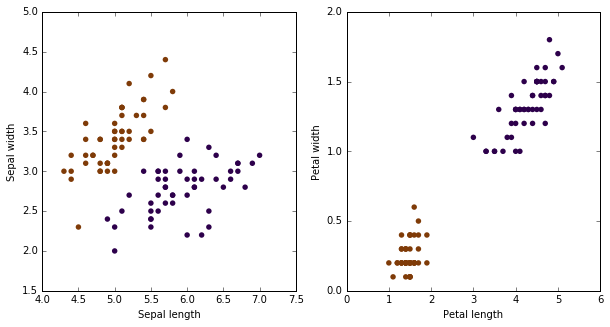

In [8]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [226]:
pred_iris = Clustering(k = 2, linkage = 'complete').fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


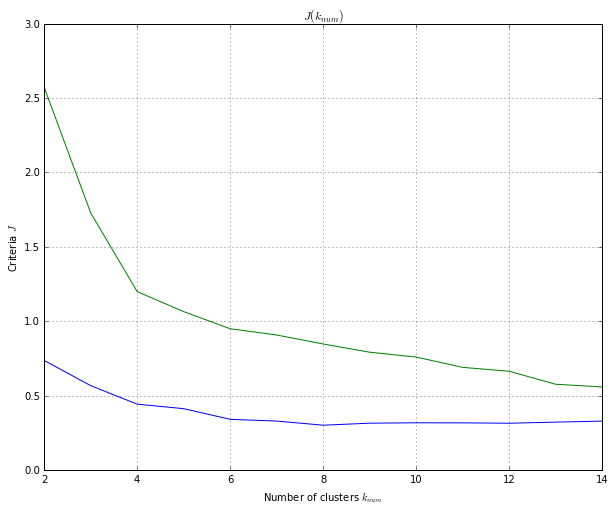

In [296]:
ks = range(2, 15)
criteria_s = np.zeros(len(ks))
criteria_d = np.zeros(len(ks))
for i, k_num in enumerate(ks):
    cls = Clustering(k = k_num, linkage = 'average')
    y = cls.fit_predict(x_iris)
    criteria_s[i] = quality(x_iris, y)
    criteria_d[i] = diameter(x_iris, y)
    
pl.figure(figsize=(10, 8))
pl.plot(ks, criteria_s)
pl.plot(ks, criteria_d)
pl.title("$J(k_{num})$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k_{num}$")
pl.grid()
pl.show()

Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [321]:
#@timer
def quality(x, y, _type):
    if _type == 'inertia':
        return inertia(x, y)
    elif _type == 'diameter':
        return diameter(x, y)
    elif _type == 'silhouette':
        return silhouette(x, y)
        #return smt.silhouette_score(x, y)
    else:
        raise ValueError('Unknown criteria')

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

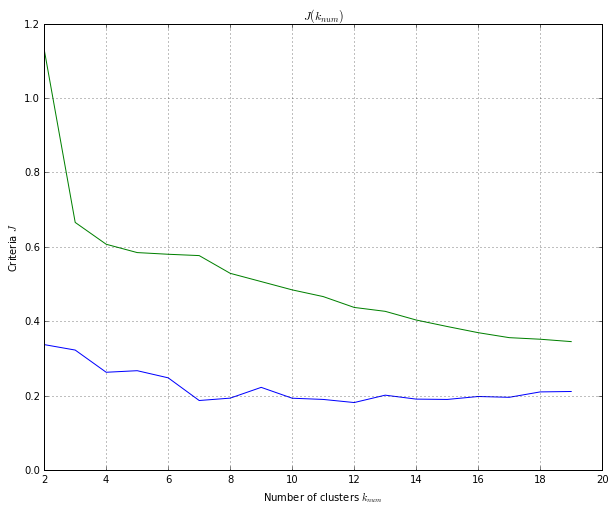

In [325]:
ks = range(2, 20)
criteria_s = np.zeros(len(ks))
criteria_d = np.zeros(len(ks))
dataset = x[::40]
for i, k_num in enumerate(ks):
    cls = Clustering(k = k_num, linkage = 'complete')
    y = cls.fit_predict(dataset)
    criteria_s[i] = quality(dataset, y, 'silhouette')
    criteria_d[i] = quality(dataset, y, 'diameter')
    
pl.figure(figsize=(10, 8))
pl.plot(ks, criteria_s)
pl.plot(ks, criteria_d)
pl.title("$J(k_{num})$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k_{num}$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [290]:
cl_num = 4
cls = Clustering(k = cl_num)
y = cls.fit_predict(x)

In [330]:
# reduced dataset
X = x[::20]
cl_num = 4
cls = Clustering(k = cl_num, linkage = 'complete')
y = cls.fit_predict(X)

Time: 434.563844


Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 345 / 345
[t-SNE] Mean sigma: 0.142373
[t-SNE] Error after 100 iterations with early exaggeration: 0.818978
[t-SNE] Error after 175 iterations: 1.661043


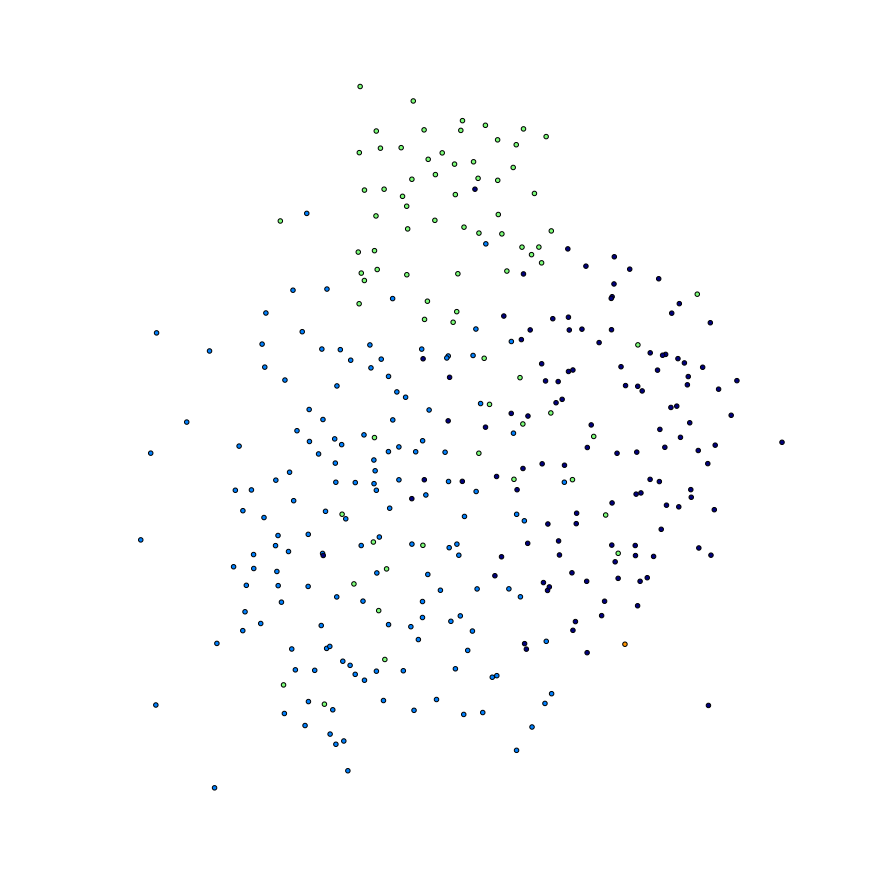

In [331]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(X)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / cl_num), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

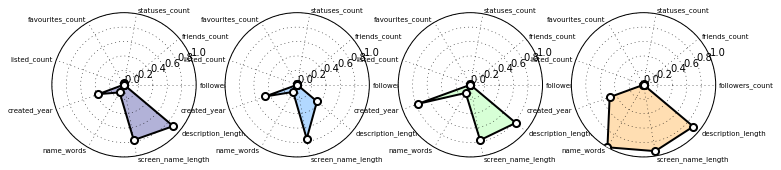

In [332]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = X[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(5, 5, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / cl_num))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.